In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu
from tensorflow.keras.regularizers import L2
from tensorflow.keras import regularizers

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import os
import gc
import numpy as np
import pickle

from sklearn.preprocessing import StandardScaler

from src import modules
from src.model import NAM

device = tf.config.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(device,True)

In [2]:
n_fig_cols = 4
x_n_blocks = 30
color: list = [0.9, 0.4, 0.4]
batch_size = 128

ss = StandardScaler()
with open(os.path.join('data','Internet.pkl'),'rb') as f:
    dataset = pickle.load(f)

train_x,train_y,valid_x,valid_y,test_x,test_y,column_x,unique_target = dataset.values()

unique_dict = dict(
    train = {n: np.unique(x) for n, x in enumerate(train_x.transpose())},
    valid = {n: np.unique(x) for n, x in enumerate(valid_x.transpose())},
    test  = {n: np.unique(x) for n, x in enumerate(test_x.transpose())}
)

train_x = ss.fit_transform(train_x)
valid_x = ss.transform(valid_x)
test_x = ss.transform(test_x)
    
n_class = np.unique(train_y).shape[0]
n_feature = train_x.shape[-1]

inv_unique_target = {i:j for j,i in unique_target.items()}

In [3]:
auc = tf.keras.metrics.AUC(multi_label = True,num_labels = n_class)

nam = NAM(

    n_feature = n_feature,
    exu_unit = 1000,
    linear_unit = [64,32],
    mode = 'cls', # choose one of 'reg' or 'cls'
    n_class = n_class,  # For regression, NAM should has only one output, but also using multi-output regression
    dropout_ratio = .1, # The one of options for regularization
    layer_regularization = 1e-3, # The another of options for regularization
    feature_regularization = 1e-3,
    first_layer_type = 'Linear',
    
)

nam.compile(
    optimizer = tf.optimizers.Adam(),
    loss = nam.loss_fn, 
    metrics = auc
)

nam.fit(
    train_x,np.eye(n_class)[train_y],
    batch_size = batch_size,
    epochs = 10,
    validation_data = (valid_x,np.eye(n_class)[valid_y]),
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            patience = 5, restore_best_weights=True,
        )
    ]
)

Epoch 1/10
342/342 [==============================] - 8s 14ms/step - loss: 1.3252 - auc: 0.8480 - val_loss: 0.8652 - val_auc: 0.8718
Epoch 2/10
342/342 [==============================] - 4s 12ms/step - loss: 0.8626 - auc: 0.8688 - val_loss: 0.8368 - val_auc: 0.8709
Epoch 3/10
342/342 [==============================] - 4s 13ms/step - loss: 0.8462 - auc: 0.8692 - val_loss: 0.8282 - val_auc: 0.8709
Epoch 4/10
342/342 [==============================] - 4s 13ms/step - loss: 0.8389 - auc: 0.8692 - val_loss: 0.8236 - val_auc: 0.8702
Epoch 5/10
342/342 [==============================] - 4s 13ms/step - loss: 0.8336 - auc: 0.8690 - val_loss: 0.8171 - val_auc: 0.8711
Epoch 6/10
342/342 [==============================] - 4s 13ms/step - loss: 0.8296 - auc: 0.8694 - val_loss: 0.8139 - val_auc: 0.8709
Epoch 7/10
342/342 [==============================] - 4s 13ms/step - loss: 0.8270 - auc: 0.8691 - val_loss: 0.8111 - val_auc: 0.8711
Epoch 8/10
342/342 [==============================] - 4s 13ms/step - 

In [4]:
from matplotlib import pyplot as plt
import seaborn as sbn
import matplotlib.patches as patches

from sklearn.metrics import confusion_matrix
import pandas as pds
import matplotlib as MP

In [5]:
preds = nam.predict(test_x)

confusion_matrix(test_y,preds.argmax(1))

array([[6155,   67,   52,    0],
       [   0, 2142,    0,    0],
       [   3,  120, 2374,    0],
       [   3,    0,    6,    0]])

In [6]:
def list_chunk(lst, n):
    return [lst[i:i+n] for i in range(0, len(lst), n)]

data = list_chunk(train_x ,batch_size)
total_contribution = tf.concat([nam.extract(x,False) for x in data],0)

cont_list = []
for idx,value in zip(train_y,total_contribution):
    cont_list.append(value[:,idx])

cont_list = np.stack(cont_list)

scaler09 = lambda x: x  / x.sum() * .9

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-pack

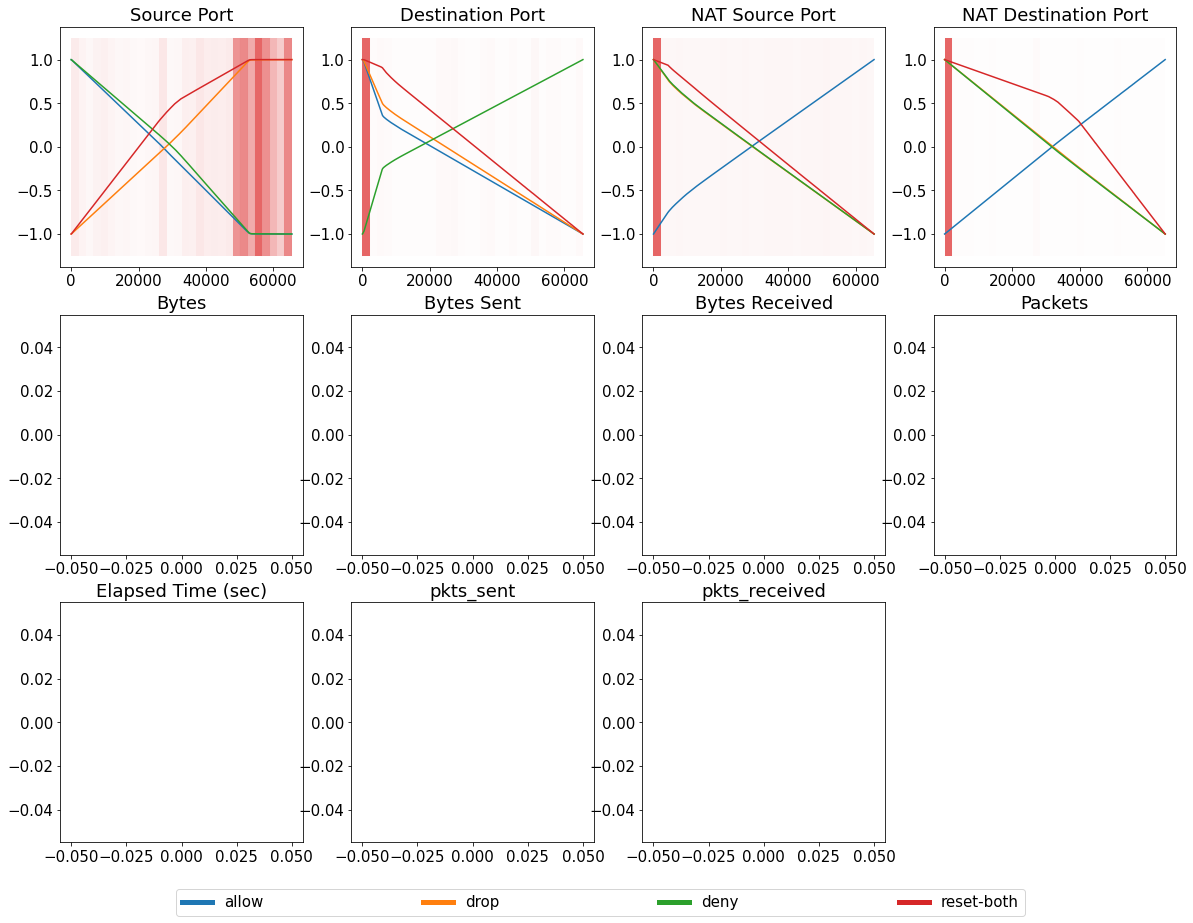

In [7]:
plt.rcParams['font.size'] = 15


SScaling = lambda x: 2 * ((x - x.min(0)) / (x.max(0) - x.min(0))) - 1

data = test_x

n_fig_rows = n_feature // n_fig_cols
if n_feature % n_fig_cols != 0:
    n_fig_rows += 1

fig = plt.figure(figsize = (n_fig_cols * 5,n_fig_rows * 5))
for n_fig,fn in enumerate(range(n_feature),1):
    
    x = data[:,fn]
    unique_x = np.unique(x)
    extracted_features = nam.features_list[fn](unique_x[:,np.newaxis],False).numpy()
    extracted_features = SScaling(extracted_features)
    
    ax = fig.add_subplot(n_fig_rows,n_fig_cols,n_fig)
    axes_x = [unique_dict['test'][fn]] * n_class
    for fx,fy in zip(axes_x,extracted_features.transpose()):
        ax.plot(fx,fy)
    ax.set_title(column_x[fn])
    
    max_x,min_x = unique_dict['test'][fn].max(), unique_dict['test'][fn].min()
    max_y,min_y = extracted_features.max(), extracted_features.min()
    
    density, bins = np.histogram(x,30)
    normed_density = density / density.max()
    segments = (max_x - min_x) / x_n_blocks
    
    rect_params = []

    for p in range(x_n_blocks):
        start_x = min_x + segments * p
        end_x = min_x + segments * (p + 1)
        d = min(1.0, 0.01 + normed_density[p])
        rect_params.append((d, start_x, end_x))

    for param in rect_params:
        alpha, start_x, end_x = param
        rect = patches.Rectangle(
            (start_x, min_y - .25),
            end_x - start_x,
            max_y - min_y + .5,
            linewidth=0.01,
            edgecolor=color,
            facecolor=color,
            alpha=alpha,
        )
        ax.add_patch(rect)

fig.legend(
    handles = [
        MP.patches.mlines.Line2D(
            [],[],linewidth = 5, color = color, label = col
        ) for col,color in zip(unique_target.keys(),MP.colors.TABLEAU_COLORS.values())
    ], mode = 'expand', ncol = len(unique_target.keys()), 
    loc = 'lower center',bbox_to_anchor = (0.2,.05,.6,1)
)


In [8]:
spec_class = dict()
for numb_class in range(4):
    spec_test_x = test_x[test_y == numb_class]
    idx = list(range(len(spec_test_x)))
    np.random.shuffle(idx)
    extract_class = nam.extract(spec_test_x[idx,:],False)
    spec_class[numb_class] = np.concatenate([extract_class[0].numpy(),nam.b.numpy()[np.newaxis,...]])

,Class: allow,Class: drop,Class: deny,Class: reset-both
Source Port,0.358819,-2.783908,1.125175,-0.953585
Destination Port,0.323655,0.924047,-1.826571,-0.937736
NAT Source Port,47.605705,-42.869640,-32.314930,-6.206621
NAT Destination Port,0.063861,0.103308,0.002639,-0.950688
Bytes,0.029932,0.065709,-0.041305,-0.317166
Bytes Sent,-0.033935,0.080970,0.000885,-1.102569
Bytes Received,-0.027443,0.106091,-0.018974,-0.889894
Packets,-0.046907,0.074880,-0.043591,-1.183108
Elapsed Time (sec),-0.049090,0.060939,-0.037520,-0.778252
pkts_sent,0.009435,0.107415,0.005413,-0.396233


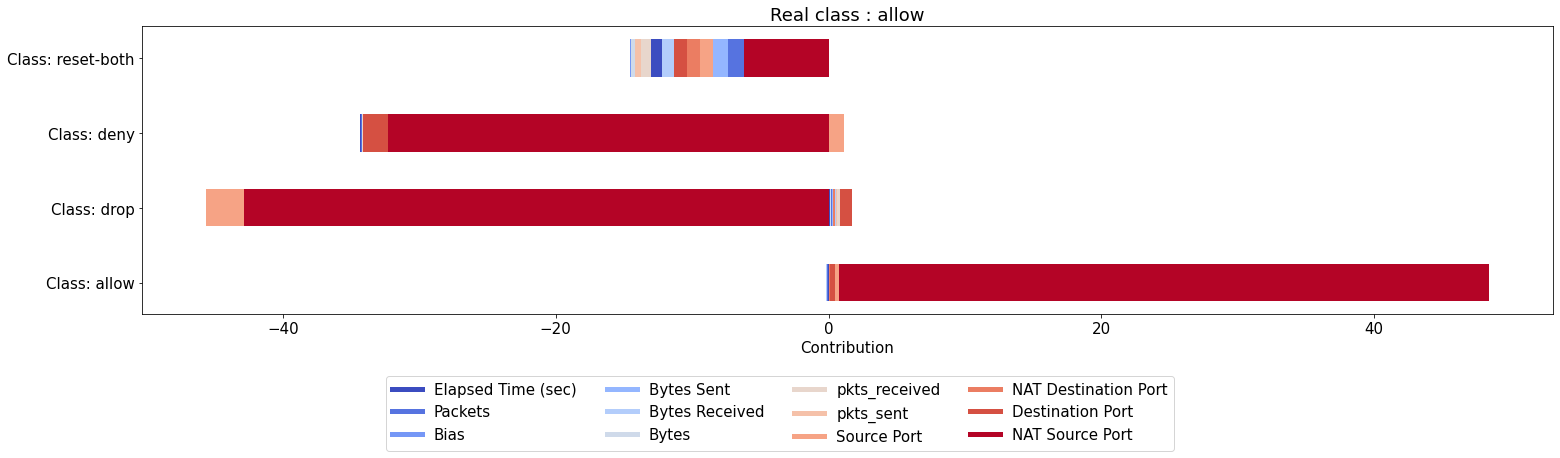

In [9]:
plt.rcParams['font.size'] = 15

sample_numb = 0


my_cmap = plt.get_cmap("coolwarm")
rescale = lambda y, Min, Max: (y - Min) / (Max - Min)

sample_data = spec_class[sample_numb]

cont_df = pds.DataFrame(
    sample_data,
    columns = (f'Class: {inv_unique_target[n]}' for n in range(n_class)), 
    index = list(column_x) + ['Bias']
)

bias_cont_list = np.concatenate([cont_list.mean(0),[nam.b.numpy().mean(0)]])
bias_columns_x_list = np.array(list(column_x) + ['Bias'])
color_dict = {
    col : my_cmap(n * 255 // n_feature) for n,col in enumerate(
        bias_columns_x_list[np.argsort(bias_cont_list)])}

fig = plt.figure(figsize = (20,5))
ax = fig.add_axes((.01, .4, .98, .8))

for n,(cls_x,df_x) in enumerate(cont_df.iteritems()):
    df_x = df_x.sort_values()
    Min,Max = df_x.min(), df_x.max()
    
    neg_df = df_x.loc[df_x < 0]
    pos_df = df_x.loc[df_x >= 0]
    
    prev_x = 0
    for col,x in neg_df.iteritems():
        ax.barh(height = .5, y = n, width = x, left = prev_x,color = color_dict[col])
        prev_x += x
        
    prev_x = 0
    for col,x in pos_df.iteritems():
        ax.barh(height = .5, y = n, width = x, left = prev_x,color = color_dict[col])
        prev_x += x
        
        
ax.set_yticks(range(n_class))
ax.set_yticklabels((f'Class: {inv_unique_target[n]}' for n in range(n_class)))
ax.set_title(f'Real class : {inv_unique_target[sample_numb]}')
ax.set_xlabel('Contribution')

fig.legend(handles = [
    MP.patches.mlines.Line2D([],[],5,color = color_dict[col], label = col) for \
    col in color_dict.keys()
],ncol = n_fig_cols,loc = 'lower center')

cont_df